Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


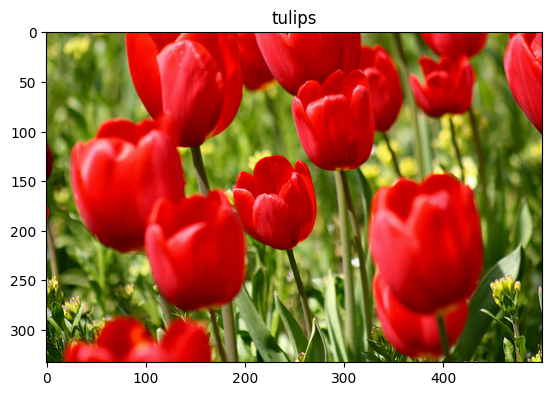

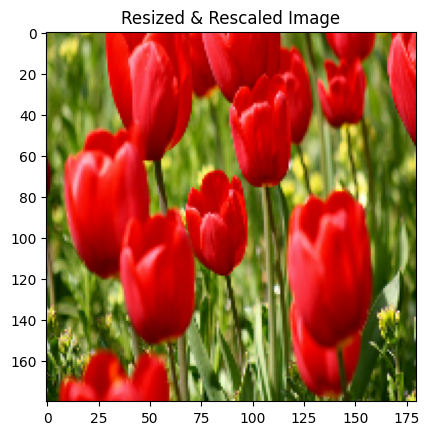

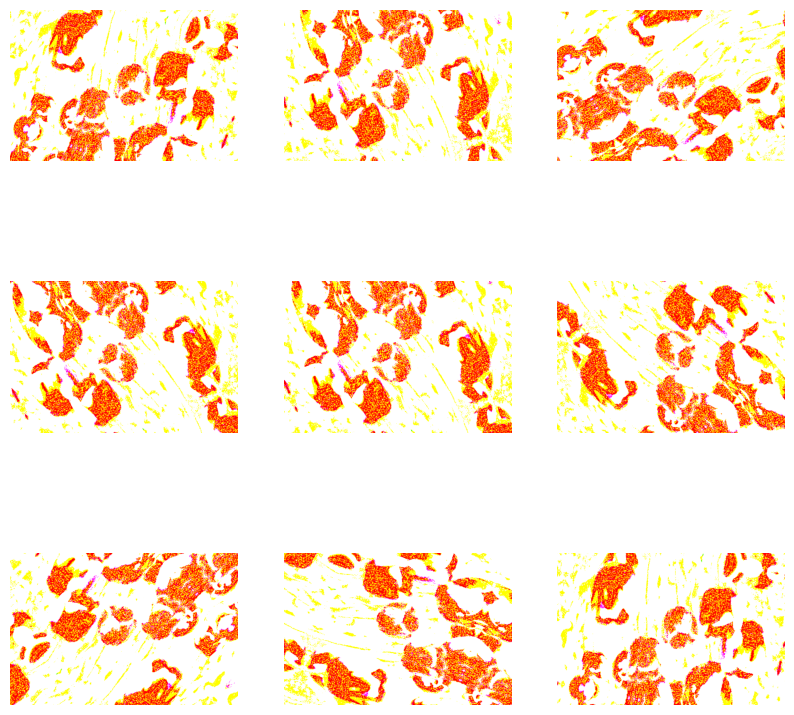

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.3397 - loss: 1.6768 - val_accuracy: 0.5613 - val_loss: 1.1267
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5466 - loss: 1.1196 - val_accuracy: 0.5967 - val_loss: 1.0568
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.5828 - loss: 1.0243 - val_accuracy: 0.6349 - val_loss: 0.9936
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.6171 - loss: 0.9434 - val_accuracy: 0.6621 - val_loss: 0.9516
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6420 - loss: 0.9168 - val_accuracy: 0.6376 - val_loss: 0.9036
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 412ms/step - accuracy: 0.6773 - loss: 0.8735

Test Accuracy: 0.6866484880447388


In [1]:
# ✅ Import necessary libraries
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

# ✅ Load TF Flowers dataset
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

# ✅ Define label name function
get_label_name = metadata.features['label'].int2str

# ✅ Retrieve a sample image
image, label = next(iter(train_ds))
plt.imshow(image)
plt.title(get_label_name(label))
plt.show()

# ✅ Define resizing & rescaling layers
IMG_SIZE = 180
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
])

# ✅ Apply resizing & rescaling to a sample image
result = resize_and_rescale(image)
plt.imshow(result)
plt.title("Resized & Rescaled Image")
plt.show()

# ✅ Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# ✅ Visualize augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(tf.expand_dims(image, 0))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")
plt.show()

# ✅ Prepare datasets with augmentation
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.batch(batch_size)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

# ✅ Build a simple CNN model
model = tf.keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5)  # 5 flower classes
])

# ✅ Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# ✅ Train the model
model.fit(train_ds, validation_data=val_ds, epochs=5)

# ✅ Evaluate the model on test dataset
test_loss, test_acc = model.evaluate(test_ds)
print("\nTest Accuracy:", test_acc)
